# CWRU Experiments
## Imports

In [1]:
import pandas as pd
import numpy as np

import lib.transformers as tf
from sklearn.pipeline import Pipeline

from lib.models import Ganomaly1d, Ganomaly2d, GanomalyFE, GanomalyNet
from lib.visualization import GANomalyBoard, rename_tensorboard_key

from skorch.callbacks import PassthroughScoring, ProgressBar
import torch

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
import tensorflow

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lib.others import create_dataset

from lib.others import build_model
from lib.visualization import lineplot_comparison

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwruData0 = pd.read_parquet('data/cwru0.parquet')
cwruData1 = pd.read_parquet('data/cwru1.parquet')

cwruData = pd.concat([cwruData0, cwruData1])

## Settings

In [3]:
torch.manual_seed(0)

## Creating Datasets

In [4]:
normal_features, normal_labels = create_dataset(cwruData, feature_columns = ['fanEndData', 'driveEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Normal Baseline'], sampleRate = [12000])
normal_features_train, normal_features_test, normal_labels_train, normal_labels_test = train_test_split(normal_features, normal_labels, train_size = 400, test_size= 451, random_state = 0)

ball_features, ball_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Ball Fault'], sampleRate = [12000])
inner_features, inner_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Inner Race Fault'], sampleRate = [12000])
outer_features, outer_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Outer Race Fault'], sampleRate = [12000])


labels_test = pd.concat([ball_labels, inner_labels, outer_labels, normal_labels_test])
features_test = pd.concat([ball_features, inner_features, outer_features, normal_features_test])

normal_features_test = np.array(normal_features_test.to_list())
normal_features_train = np.array(normal_features_train.to_list())

## Data Preparation
Building a pipeline of custom transformers to fetch and preprocess CWRU data.

In [5]:
max_epochs = 3

ganomaly_timeseries = build_model(Ganomaly1d, 3136, max_epochs, 'timeseries444', plot_type = 'lineplot', plot_shape = 3136, plot_latent_shape =600, n_samples = 4)
ganomaly_stacked_ts = build_model(Ganomaly2d, 56, max_epochs, 'stacked_timeseries444', plot_type = 'lineplot', plot_shape = 3136, plot_latent_shape =600, n_samples = 4)
ganomaly_fft = build_model(Ganomaly1d, 1568, max_epochs, 'fourier_transform444', plot_type = 'lineplot', plot_shape = 1568, plot_latent_shape =600, n_samples = 4)
ganomaly_stft = build_model(Ganomaly2d, 56, max_epochs, 'short_term_fourier444', plot_type = 'image', plot_shape = 56, plot_latent_shape =600, n_samples = 36)
ganomaly_fe = build_model(GanomalyFE, 4, max_epochs, 'feature_extraction444', needs_feature_engineering = True, plot_type = 'barplot', plot_shape = 16, n_samples = 4, plot_latent_shape = 32)

model_timeseries = \
Pipeline(steps=[
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper', tf.ArrayReshaper((1, 3136))),
                ('Model', ganomaly_timeseries)
               ])

model_stacked_ts = \
Pipeline(steps=[
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper', tf.ArrayReshaper((1, 56, 56))),
                ('Model', ganomaly_stacked_ts)
               ])

model_fe = \
Pipeline(steps=[
                ('FeatureExtractor', tf.FeatureExtractor(axis = 1)),
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper', tf.ArrayReshaper((1, 4, 4))),
                ('Model', ganomaly_fe)
               ])

model_stft = \
Pipeline(steps=[
                ('ArraySTFT', tf.ArraySTFT()),
                ('ArrayReshaper', tf.ArrayReshaper((3136))),
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper2', tf.ArrayReshaper((1, 56, 56))),
                ('Model', ganomaly_stft)
               ])

model_fft = \
Pipeline(steps=[
                ('ArrayFFT', tf.ArrayFFT()),
                ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper2', tf.ArrayReshaper((1, 1568))),
                ('Model', ganomaly_fft)
               ])

model_timeseries.fit(normal_features_train)
model_stacked_ts.fit(normal_features_train)
model_fe.fit(normal_features_train)
model_stft.fit(normal_features_train)
model_fft.fit(normal_features_train)

  epoch    loss_dis    loss_gen    loss_gen_app    loss_gen_fra    loss_gen_lat    train_loss      dur
-------  ----------  ----------  --------------  --------------  --------------  ------------  -------
      1      0.6009     11.5942          0.3236          0.8026          1.0831       12.1951  35.5065
      2      0.3313      6.0910          0.1620          0.8000          0.4307        6.4223  33.1497
      3      0.2114      5.0899          0.1351          0.8010          0.2367        5.3013  36.1706
  epoch    loss_dis    loss_gen    loss_gen_app    loss_gen_fra    loss_gen_lat    train_loss      dur
-------  ----------  ----------  --------------  --------------  --------------  ------------  -------
      1      0.3719     13.2638          0.3897          0.7755          0.7988       13.6357  30.8317
      2      0.0674      6.6815          0.1890          0.7804          0.2310        6.7489  31.0743
      3      0.0299      5.1355          0.1412          0.7821          

Pipeline(steps=[('ArrayFFT', ArrayFFT()), ('StandardScaler', MinMaxScaler()),
                ('ArrayReshaper2', ArrayReshaper(shape=(1, 1568))),
                ('Model',
                 <class 'lib.models.GanomalyNet'>[initialized](
  module_=Ganomaly1d(
    (l_fra): BCELoss()
    (l_app): L1Loss()
    (l_dis): L1Loss()
    (discriminator): DiscriminatorNet1d(
      (features): Sequential(
        (0): Conv1d(1, 64, kernel_size=(16,), stride=(8,), pa...
          (pyramid-relu-128): LeakyReLU(negative_slope=0.2, inplace=True)
          (pyramid-128-256-convt): Conv1d(128, 256, kernel_size=(16,), stride=(4,), bias=False)
          (pyramid-256-batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pyramid-relu-256): LeakyReLU(negative_slope=0.2, inplace=True)
          (final-256-1-convt): Conv1d(256, 600, kernel_size=(9,), stride=(1,), bias=False)
        )
      )
    )
  ),
))])

# GridSearchCV

In [6]:
search_parameters = {
    'module_w_fra': list(range(0, 101, 10)),
    'module_w_app': list(range(0, 101, 10)),
    'module_w_lat': list(range(0, 101, 10)),
}

In [7]:
#ganomaly_gs = GridSearchCV(ganomaly, search_parameters, refit=False, cv=4)

In [8]:
#ganomaly_gs.fit(train)

## Results


### Timeseries

In [9]:
features_test = np.array(features_test.tolist())
predictions = model_timeseries.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

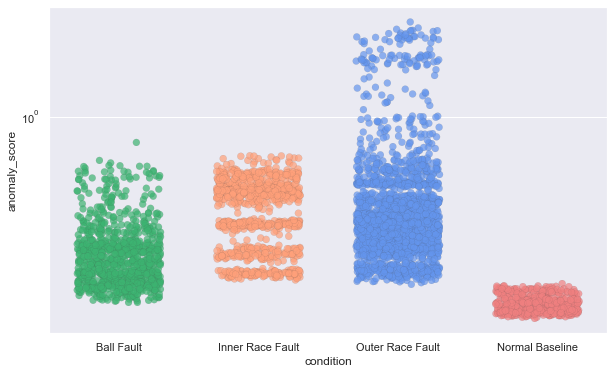

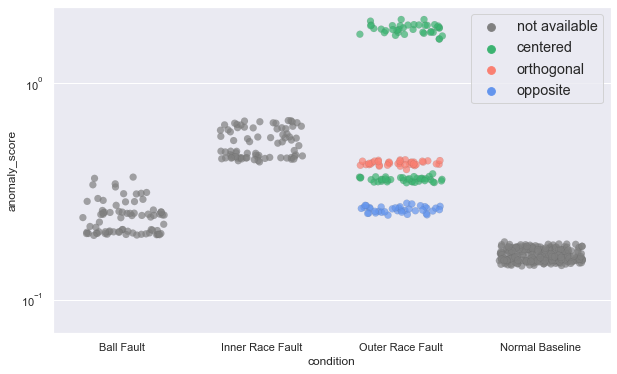

In [10]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]


fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

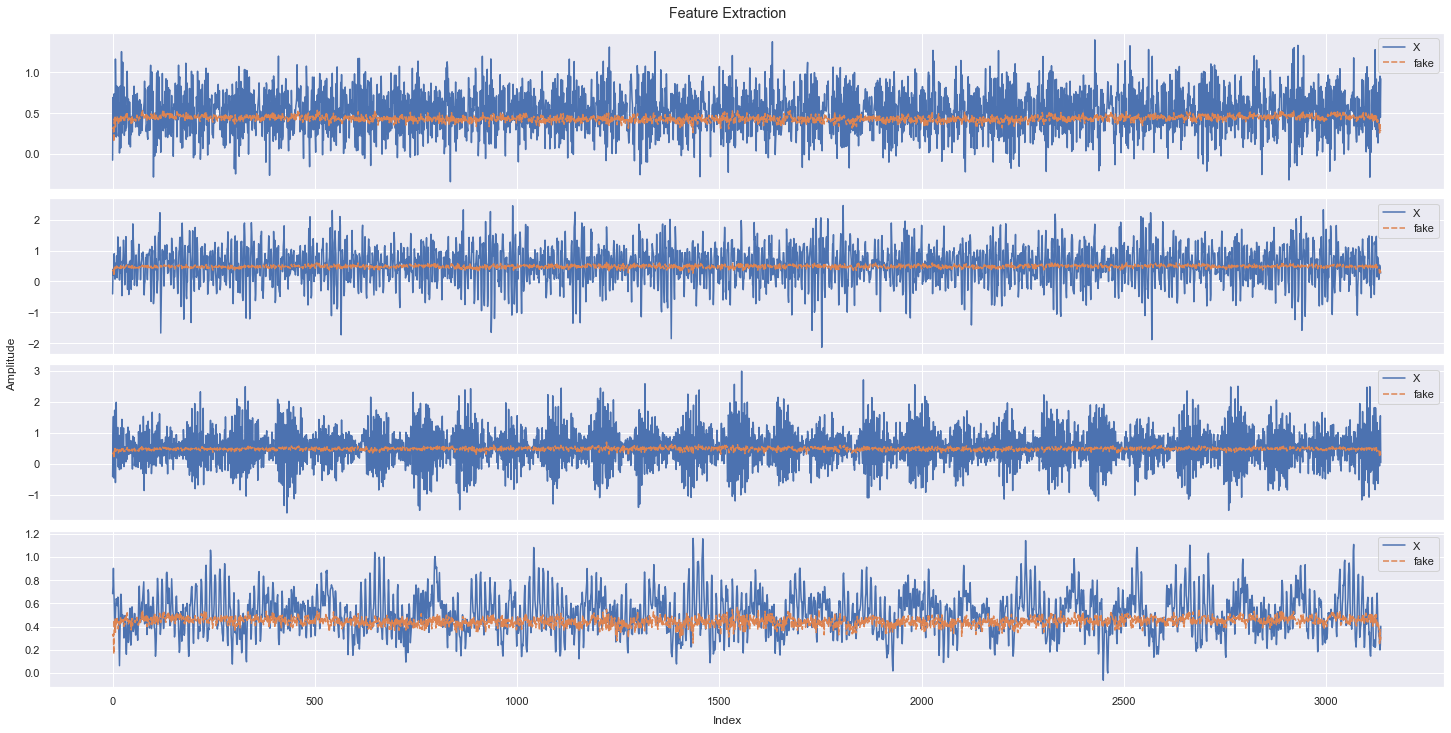

In [11]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

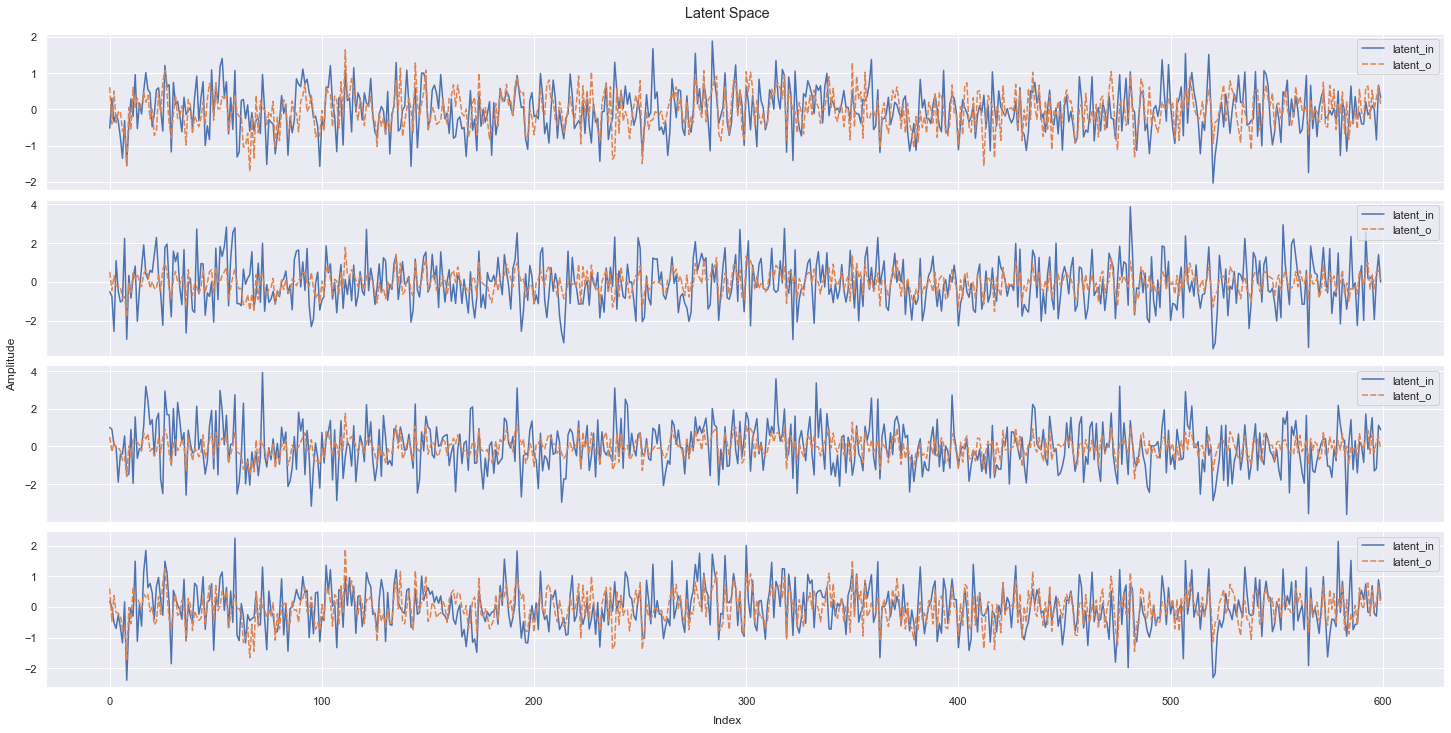

In [12]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### Stacked Timeseries

In [13]:
features_test = np.array(features_test.tolist())
predictions = model_stacked_ts.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

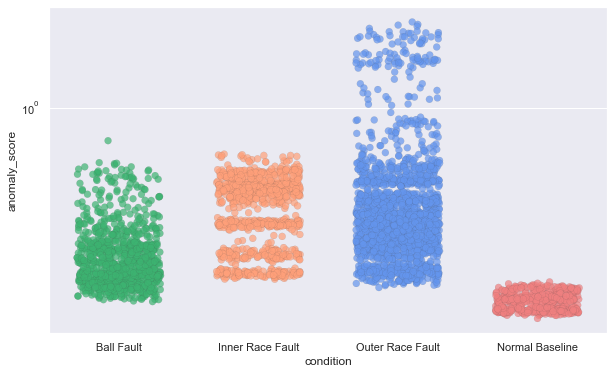

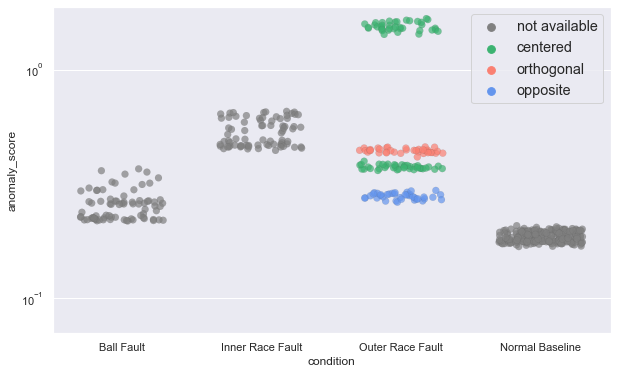

In [14]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

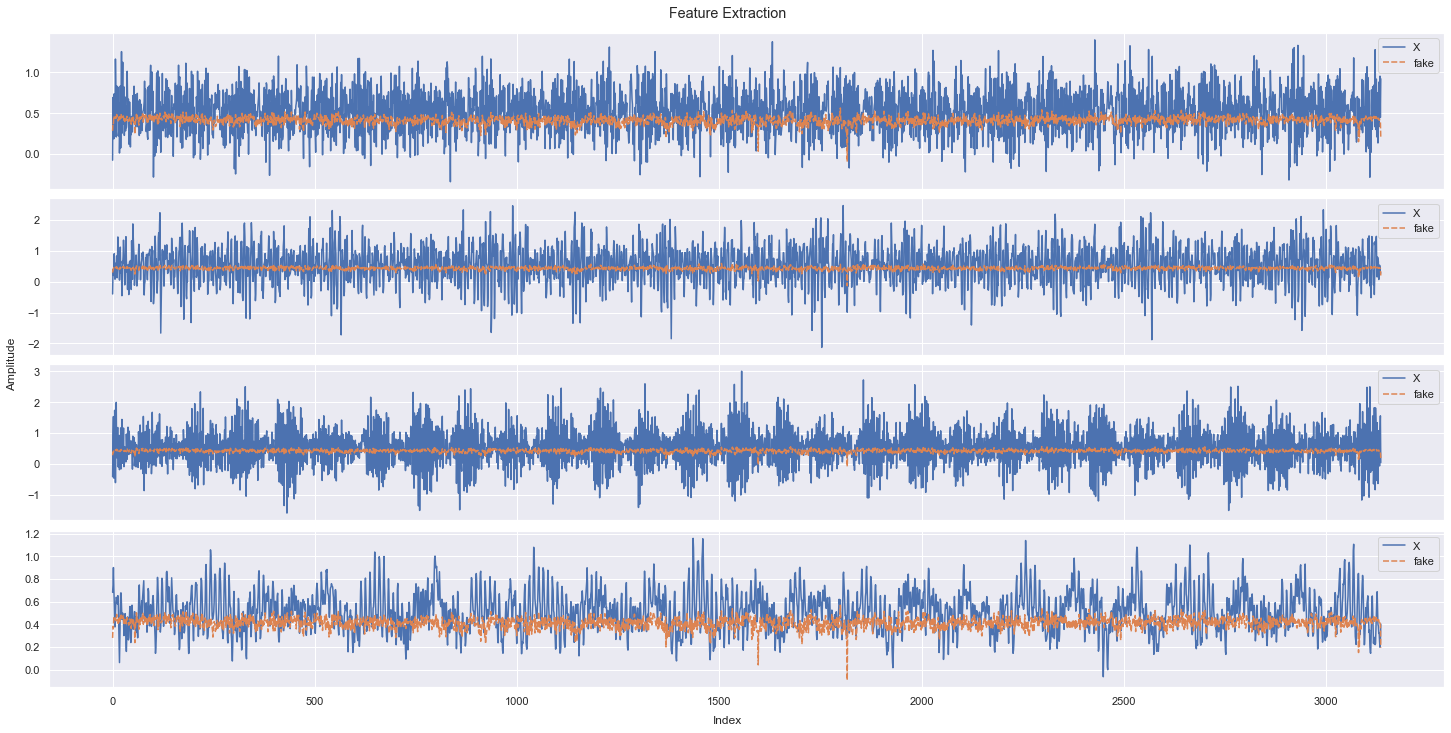

In [15]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

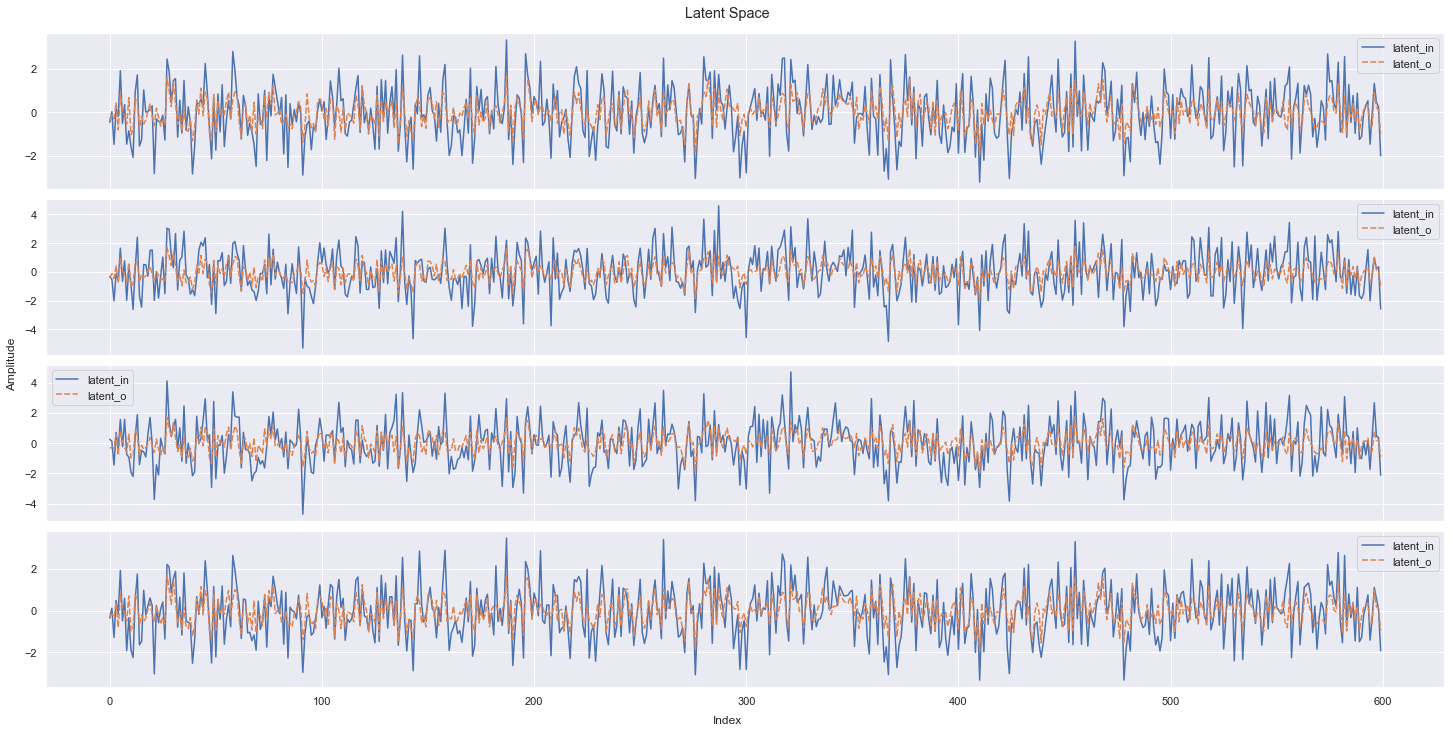

In [16]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### FFT

In [17]:
features_test = np.array(features_test.tolist())
predictions = model_fft.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

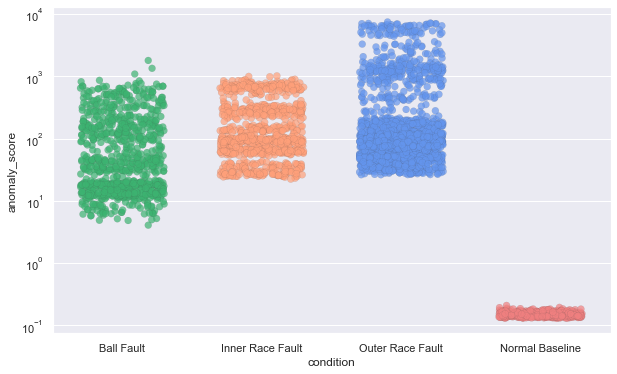

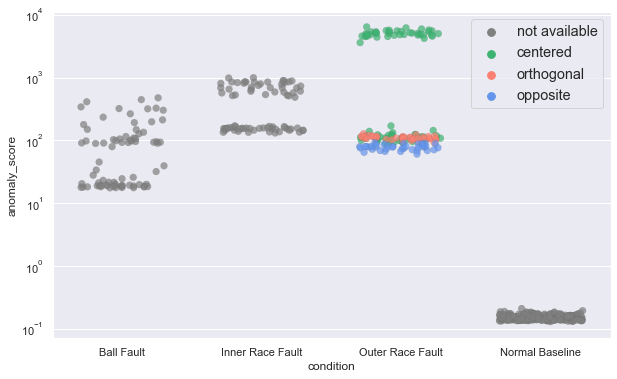

In [18]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

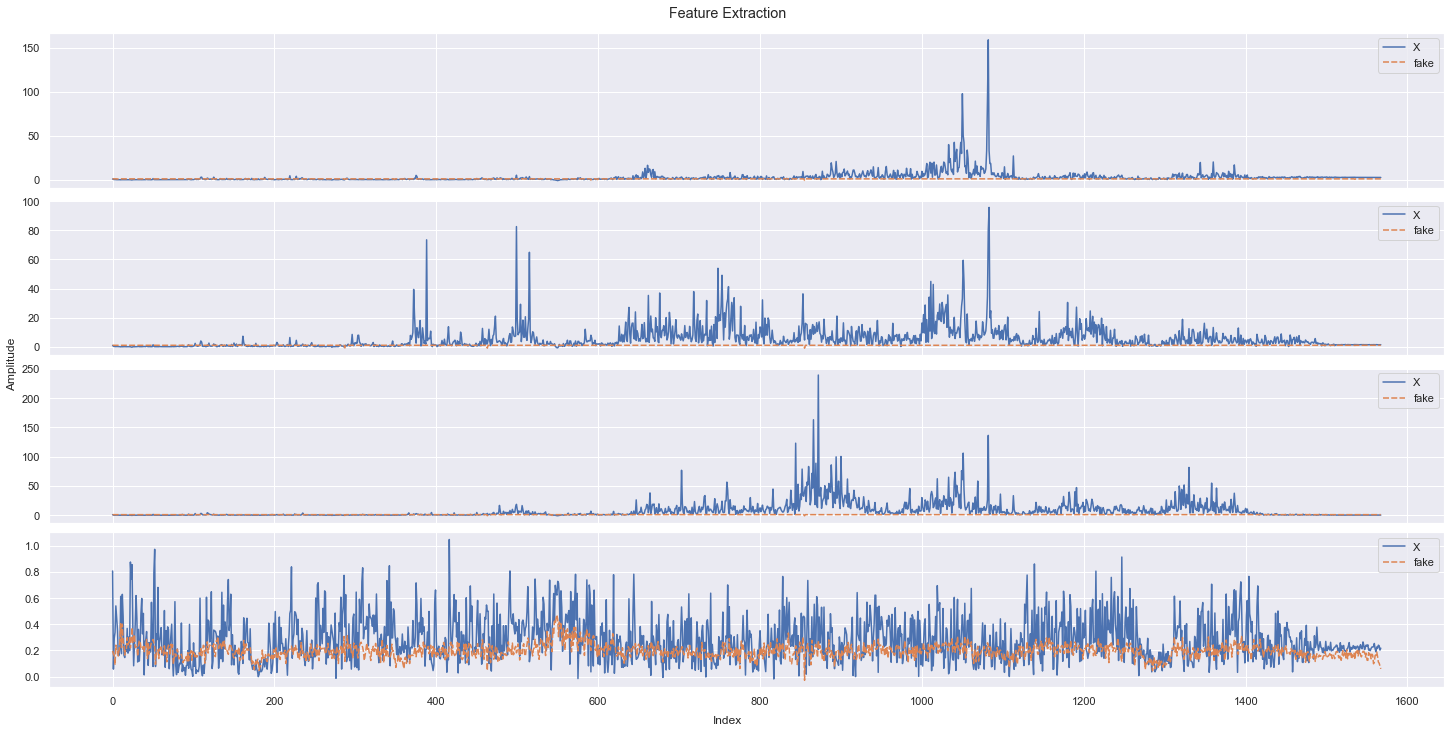

In [19]:
lineplot_comparison(result, 'X', 'fake', 'Feature Extraction', 'Index', 'Amplitude')

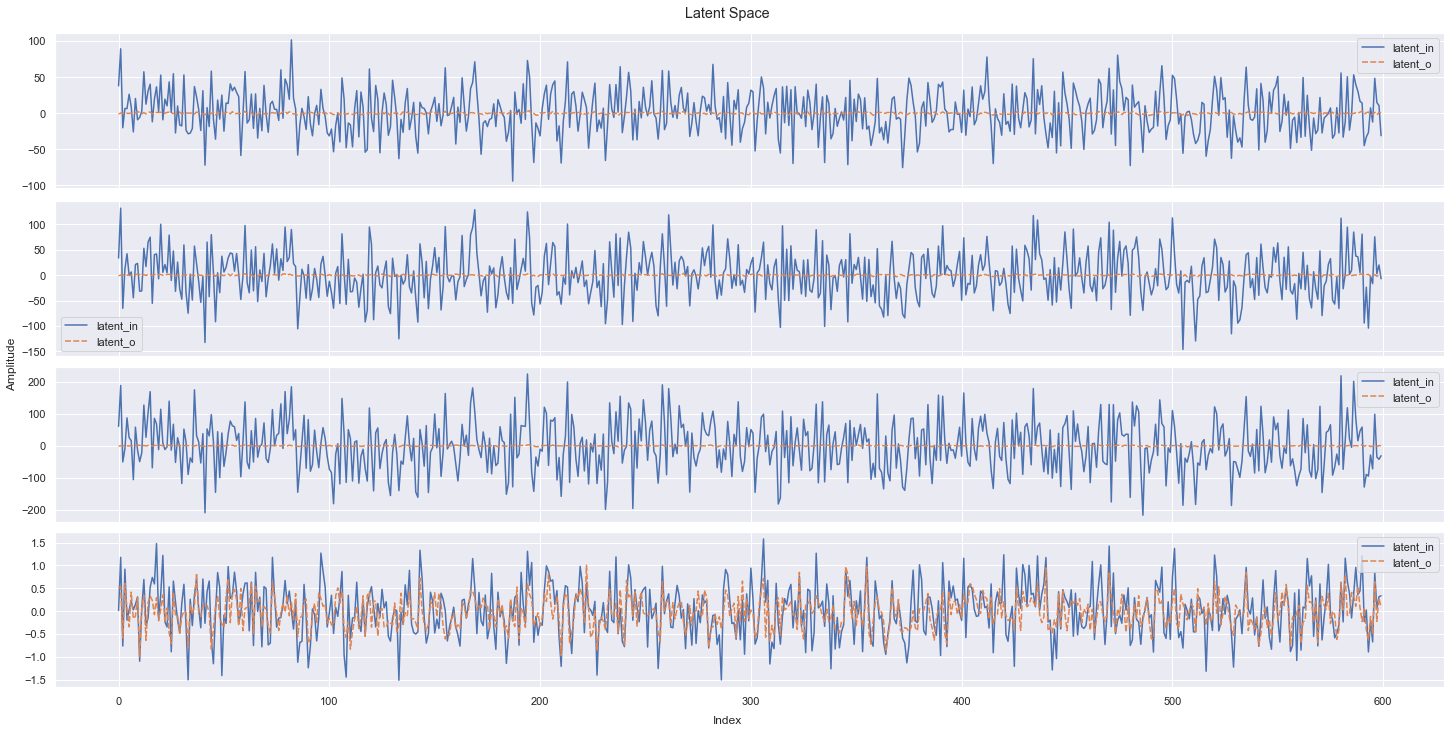

In [20]:
lineplot_comparison(result, 'latent_in', 'latent_o', 'Latent Space', 'Index', 'Amplitude')

### STFT

In [21]:
features_test = np.array(features_test.tolist())
predictions = model_stft.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

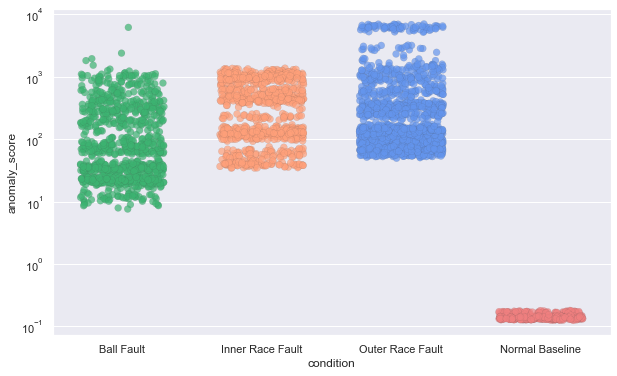

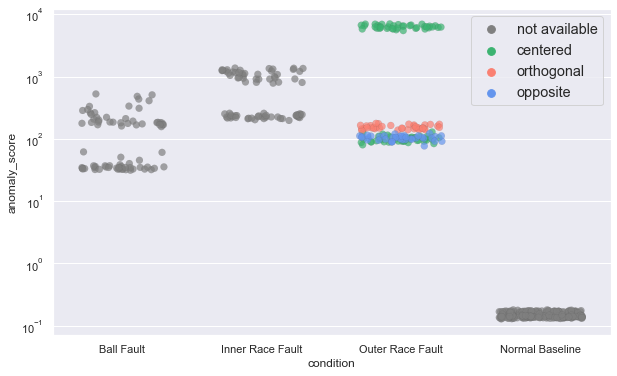

In [22]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')

### Feature Extraction

In [23]:
features_test = np.array(features_test.tolist())
predictions = model_fe.predict_proba(features_test)

predictions = pd.DataFrame(predictions)
predictions = predictions.T
predictions = predictions.rename({0: 'anomaly_score', 1: 'X', 2: 'fake', 3: 'latent_in', 4: 'latent_o'}, axis = 1)

columns_flatten = ['X', 'fake', 'latent_in', 'latent_o']
predictions[columns_flatten] = predictions[columns_flatten].applymap(lambda array: array.flatten())


result = labels_test.reset_index(drop=True).join(predictions)
result  = result.reset_index(drop = True)

result['relativeFaultPosition'] = result['relativeFaultPosition'].fillna('not available')
result['faultDiameter'] = result['faultDiameter'].fillna(-1)

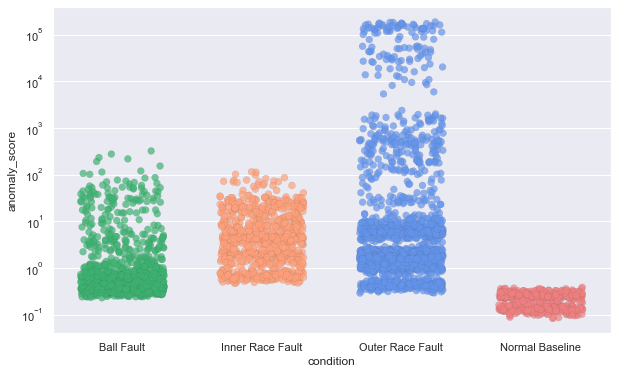

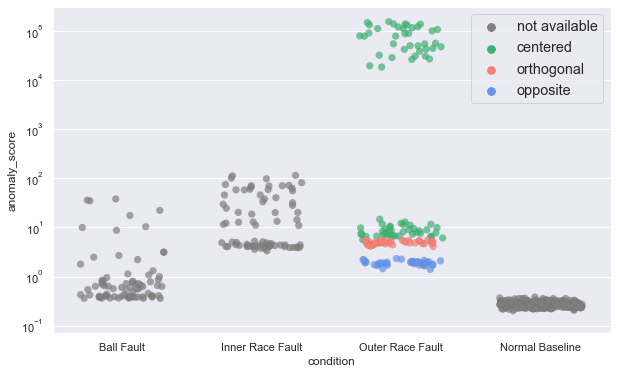

In [24]:
sns.set_style('darkgrid')


sns.set(rc={'figure.figsize':(10, 6)})
fig, ax = plt.subplots()


selection2 = result[result['index'].isin([20, 6, 160, 0, 1, 2, 3])]
sns.stripplot(data = result, y = 'anomaly_score', x = 'condition', palette = ['mediumseagreen', 'lightsalmon', 'cornflowerblue', 'lightcoral'], alpha = 0.7, jitter = 0.3,  ax = ax, linewidth = .1, size = 7)
ax.set_yscale('log')

selection = result[((result['faultDiameter'] == 0.021) & (result['motorLoad'] == 0) & (result['vibrationOrigin'] == 'fanEndData')) | (result['condition'] == 'Normal Baseline') & (result['vibrationOrigin'] == 'fanEndData')]



fig2, ax2 = plt.subplots()
sns.stripplot(data = selection, y = 'anomaly_score', x = 'condition', hue = 'relativeFaultPosition', palette = ['grey', 'mediumseagreen', 'salmon', 'cornflowerblue'], ax = ax2, alpha = 0.7, jitter = 0.3, linewidth = .1, size = 7)
ax2.set_yscale('log')
ax2.set(ylim=(0.07, None))
ax2.legend(fontsize='large', title_fontsize='30')